In [9]:
pip install requests beautifulsoup4 pandas yfinance requests lxml


   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ----------------------- ---------------- 2.4/4.0 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 10.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os, warnings
from typing import List, Tuple
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

SESSIONS = 5       # number of trading sessions to analyze
LOOKBACK_DAYS = 14

In [11]:
WIKI_URL = "https://en.wikipedia.org/wiki/NIFTY_50"

In [27]:
headers = {"User-Agent": "Mozilla/5.0"}
resp = requests.get(WIKI_URL, headers=headers, timeout=20)
resp.raise_for_status()

all_tables = pd.read_html(resp.text)
print("Tables found:", len(all_tables))

Tables found: 33


In [30]:
target_table = None
for tbl in all_tables:
    cols_lower = [str(c).strip().lower() for c in tbl.columns]
    if any("symbol" in c for c in cols_lower) and any("sector" in c for c in cols_lower):
        target_table = tbl.copy()
        break
if target_table is None:
    raise RuntimeError("couldn't find a table with both 'symbol' and 'sector' columns")

In [32]:
target_table.head(50)

,Company name,Symbol,Sector[15],Date added[16]
0,Adani Enterprises,ADANIENT,Metals & Mining,30 September 2022
1,Adani Ports & SEZ,ADANIPORTS,Services,28 September 2015
2,Apollo Hospitals,APOLLOHOSP,Healthcare,31 March 2022
3,Asian Paints,ASIANPAINT,Consumer Durables,27 April 2012[a]
4,Axis Bank,AXISBANK,Financial Services,27 March 2009
5,Bajaj Auto,BAJAJ-AUTO,Automobile and Auto Components,1 October 2010[b]
6,Bajaj Finance,BAJFINANCE,Financial Services,29 September 2017
7,Bajaj Finserv,BAJAJFINSV,Financial Services,2 April 2018
8,Bharat Electronics,BEL,Capital Goods,30 September 2024
9,Bharti Airtel,BHARTIARTL,Telecommunication,1 March 2004


In [33]:
target_table.columns = [str(c).strip().title() for c in target_table.columns]

In [34]:
rename_cols = {}
for c in target_table.columns:
    c_low = c.lower()
    if "symbol" in c_low:
        rename_cols[c] = "Symbol"
    elif "company" in c_low or "constituent" in c_low or "name" in c_low:
        rename_cols[c] = "Company"
    elif "sector" in c_low or "industry" in c_low:
        rename_cols[c] = "Sector"

clean = target_table.rename(columns=rename_cols)

In [36]:
#keep only the columns we care about
need = ["Symbol", "Company", "Sector"]
missing = [c for c in need if c not in clean.columns]
if missing:
    raise RuntimeError(f"expected columns not found: {missing}")

clean = clean[need].copy()

In [38]:
for c in need:
    clean[c] = (
        clean[c]
        .astype(str)
        .str.replace(r"\[.*?\]", "", regex=True)  # remove footnote markers like [a]
        .str.replace(r"\s+", " ", regex=True)     # collapse extra spaces
        .str.strip()
    )

clean = clean.dropna(subset=["Symbol"]).drop_duplicates(subset=["Symbol"]).reset_index(drop=True)

In [40]:
print("rows after cleaning:", len(clean))
display(clean.head())

rows after cleaning: 50


,Symbol,Company,Sector
0,ADANIENT,Adani Enterprises,Metals & Mining
1,ADANIPORTS,Adani Ports & SEZ,Services
2,APOLLOHOSP,Apollo Hospitals,Healthcare
3,ASIANPAINT,Asian Paints,Consumer Durables
4,AXISBANK,Axis Bank,Financial Services


In [41]:
out_csv = os.path.join(ARTIFACTS_DIR, "nifty50_constituents.csv")
clean.to_csv(out_csv, index=False)
print("saved to:", out_csv)

saved to: artifacts\nifty50_constituents.csv


In [61]:
symbols = constituents["Symbol"].tolist()
tickers = [sym + ".NS" for sym in symbols]

all_rows = []

In [62]:
for tkr in tickers:
    try:
        # get ~14 days; enough to capture 5 trading sessions
        hist = yf.Ticker(tkr).history(period="14d", interval="1d")
        hist = hist.reset_index()

        # ensure only real rows
        hist = hist.dropna(subset=["Close"]).sort_values("Date")

        # keep last 5 trading days only
        if len(hist) >= 5:
            last5_rows = hist.tail(5).copy()
            last5_rows["Symbol"] = tkr
            all_rows.append(last5_rows)

    except Exception as e:
        print("Skipping:", tkr, "-", e)

In [63]:
# combine into one dataframe
if len(all_rows) == 0:
    raise RuntimeError("No price data downloaded. Check internet or try again.")

last5 = pd.concat(all_rows, ignore_index=True)

In [64]:
print("Total rows collected:", len(last5))
display(last5.head())

Total rows collected: 250


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
0,2025-11-03 00:00:00+05:30,2484.000000,2501.899902,2457.500000,2467.000000,731108,0.0,0.0,ADANIENT.NS
1,2025-11-04 00:00:00+05:30,2479.800049,2488.899902,2390.600098,2419.800049,2072668,0.0,0.0,ADANIENT.NS
2,2025-11-05 00:00:00+05:30,2419.800049,2419.800049,2419.800049,2419.800049,0,0.0,0.0,ADANIENT.NS
3,2025-11-06 00:00:00+05:30,2425.100098,2427.100098,2307.600098,2314.300049,1978147,0.0,0.0,ADANIENT.NS
4,2025-11-07 00:00:00+05:30,2315.000000,2383.899902,2291.399902,2375.699951,1193183,0.0,0.0,ADANIENT.NS


In [65]:
# save for later use
last5.to_csv(os.path.join(ARTIFACTS_DIR, "last5_prices.csv"), index=False)
print("Saved:", os.path.join(ARTIFACTS_DIR, "last5_prices.csv"))

Saved: artifacts\last5_prices.csv


In [66]:
ARTIFACTS_DIR = "artifacts"

In [67]:
if 'constituents' not in globals():
    path_const = os.path.join(ARTIFACTS_DIR, "nifty50_constituents.csv")
    if not os.path.exists(path_const):
        raise RuntimeError("nifty50_constituents.csv not found. Please run Part 1 first.")
    constituents = pd.read_csv(path_const)

In [68]:
#Last 5 trading sessions OHLCV for each ticker
if 'last5' not in globals():
    # try parquet first, else csv
    parq_path = os.path.join(ARTIFACTS_DIR, "last5_prices.parquet")
    csv_path  = os.path.join(ARTIFACTS_DIR, "last5_prices.csv")

In [69]:
if os.path.exists(parq_path):
    last5 = pd.read_parquet(parq_path)
elif os.path.exists(csv_path):
    last5 = pd.read_csv(csv_path)
else:
    raise RuntimeError("last5 price data not found. Please run the price download step.")


In [71]:
if "Date" in last5.columns:
    last5["Date"] = pd.to_datetime(last5["Date"])

print("constituents rows:", len(constituents))
display(constituents.head())

constituents rows: 50


,Symbol,Company,Sector
0,ADANIENT,Adani Enterprises,Metals & Mining
1,ADANIPORTS,Adani Ports & SEZ,Services
2,APOLLOHOSP,Apollo Hospitals,Healthcare
3,ASIANPAINT,Asian Paints,Consumer Durables
4,AXISBANK,Axis Bank,Financial Services


In [72]:
print("last5 rows:", len(last5))
display(last5.head())

last5 rows: 250


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
0,2025-11-03 00:00:00+05:30,2484.000000,2501.899902,2457.500000,2467.000000,731108,0.0,0.0,ADANIENT.NS
1,2025-11-04 00:00:00+05:30,2479.800049,2488.899902,2390.600098,2419.800049,2072668,0.0,0.0,ADANIENT.NS
2,2025-11-05 00:00:00+05:30,2419.800049,2419.800049,2419.800049,2419.800049,0,0.0,0.0,ADANIENT.NS
3,2025-11-06 00:00:00+05:30,2425.100098,2427.100098,2307.600098,2314.300049,1978147,0.0,0.0,ADANIENT.NS
4,2025-11-07 00:00:00+05:30,2315.000000,2383.899902,2291.399902,2375.699951,1193183,0.0,0.0,ADANIENT.NS


In [73]:
# simple loop to compute per-stock momentum
rows = []

# ensure sorted
last5_sorted = last5.sort_values(["Symbol", "Date"]).copy()


In [79]:
# go ticker by ticker
for tkr in last5_sorted["Symbol"].unique():
    small = last5_sorted[last5_sorted["Symbol"] == tkr].copy()
    if len(small) != 5:
        # skip if we didn't get 5 trading rows
        continue
    first_close = float(small["Close"].iloc[0])
    last_close  = float(small["Close"].iloc[-1])

# avoid divide-by-zero
    if first_close == 0:
        continue

In [99]:
 pct_change_5 = (last_close / first_close - 2.0) * 100.0

In [100]:
rows.append({
        "Symbol_yf": tkr,          # Yahoo symbol with .NS
        "FirstClose": first_close,
        "LastClose": last_close,
        "PctChange5": pct_change_5
    })

In [101]:
stock_change = pd.DataFrame(rows)
print("per-stock rows:", len(stock_change))
display(stock_change.head())

per-stock rows: 2


,Symbol_yf,FirstClose,LastClose,PctChange5
0,WIPRO.NS,240.5,236.889999,-1.50104
1,WIPRO.NS,240.5,236.889999,-101.50104


In [88]:
stock_change["Symbol"] = stock_change["Symbol_yf"].str.replace(".NS", "", regex=False)

In [89]:
# attach Company & Sector from constituents
merged = stock_change.merge(
    constituents[["Symbol", "Company", "Sector"]],
    on="Symbol",
    how="left"
)

In [90]:
# keep neat columns
merged = merged[["Symbol", "Company", "Sector", "FirstClose", "LastClose", "PctChange5"]]
display(merged.head())

# sector average momentum
sector_momentum = (
    merged.dropna(subset=["Sector"])
          .groupby("Sector", as_index=False)["PctChange5"]
          .mean()
          .rename(columns={"PctChange5": "Avg_%Change_5"})
          .sort_values("Avg_%Change_5", ascending=False)
          .reset_index(drop=True)
)
sector_momentum = (
    merged.dropna(subset=["Sector"])
          .groupby("Sector", as_index=False)["PctChange5"]
          .mean()
          .rename(columns={"PctChange5": "Avg_%Change_5"})
          .sort_values("Avg_%Change_5", ascending=False)
          .reset_index(drop=True)
)
print("sectors found:", len(sector_momentum))
display(sector_momentum)

,Symbol,Company,Sector,FirstClose,LastClose,PctChange5
0,WIPRO,Wipro,Information Technology,240.5,236.889999,-1.50104


sectors found: 1


,Sector,Avg_%Change_5
0,Information Technology,-1.50104


In [96]:
print("Top 3 Sectors (last 5 sessions):\n")
top3 = sector_momentum.head(3)
for i in range(len(top3)):
    sect = str(top3.iloc[i]["Sector"])
    avgc = float(top3.iloc[i]["Avg_%Change_5"])
    print(f"{i+1}) {sect} — {avgc:.2f}%")

Top 3 Sectors (last 5 sessions):

1) Information Technology — -1.50%


In [97]:
out_dir = "artifacts"
os.makedirs(out_dir, exist_ok=True)

In [98]:
merged.to_csv(os.path.join(out_dir, "stock_momentum.csv"), index=False)
sector_momentum.to_csv(os.path.join(out_dir, "sector_momentum.csv"), index=False)

In [94]:
print("saved: artifacts/stock_momentum.csv")
print("saved: artifacts/sector_momentum.csv")

saved: artifacts/stock_momentum.csv
saved: artifacts/sector_momentum.csv


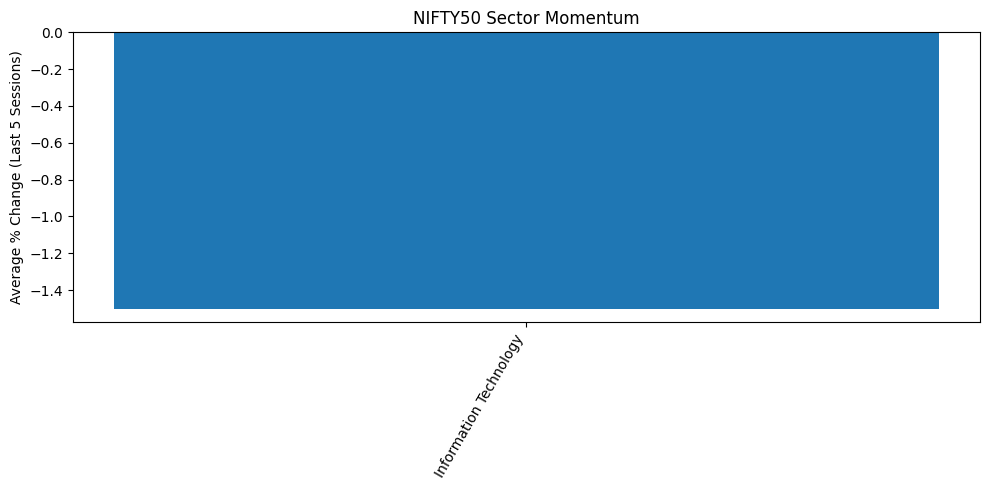

In [102]:
import matplotlib.pyplot as plt

# make sure sector_momentum exists
# it should have columns: Sector, Avg_%Change_5

plt.figure(figsize=(10,5))
plt.bar(sector_momentum["Sector"], sector_momentum["Avg_%Change_5"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Average % Change (Last 5 Sessions)")
plt.title("NIFTY50 Sector Momentum")
plt.tight_layout()
plt.show()